# HDMI Processing

This notebook is for the initial processing of the HDMI sequencing round.

We will confirm the quality of the barcodes, extract the coordinates per barcode and save these to disk, as well as prepare some files for later analyses.

The notebook has been adapted from Nova-ST GitHub (https://github.com/aertslab/Nova-ST).

This notebook works on the de-tiled fastq reads created using script `get_tiles_from_fasta.py`

In [10]:
import pysam
import collections as c
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
print("All packages loaded")

All packages loaded


Check overall nucleotide distribution of HDMIs

In [4]:
# Generated from demultiplex_per_tile.sh
tiles_fastq_dir = '/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data/' # /path/to/Demultiplexed_per_tile/output

In [5]:
tile_fastqs = [x for x in os.listdir(tiles_fastq_dir) if x.endswith('.fastq.gz')]


In [6]:
print(tile_fastqs[:5])


['AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_2_sequence_tile_1610.fastq.gz', 'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_2_sequence_tile_1509.fastq.gz', 'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_1_sequence_tile_2506.fastq.gz', 'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_2_sequence_tile_1211.fastq.gz', 'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_1_sequence_tile_1101.fastq.gz']


# Barcode structure check

We look at the reads from the first tile of the flowcell and ensure that all of the barcode reads together appear to have the expected sequence (NNVNBVNNVNNVNNVNNVNNVNNVNNVNNNNN)

In [7]:
base_pairs = c.defaultdict(lambda: c.defaultdict(lambda: 0))

In [8]:
# Grab reads from the first tile to check barcode structure
with pysam.FastqFile(f'{tiles_fastq_dir}/{tile_fastqs[0]}') as fh:
    for en, entry in enumerate(fh):
        for n, base in enumerate(entry.sequence):
            base_pairs[n][base] += 1

In [11]:
bp_df = pd.DataFrame(base_pairs)

In [12]:
bp_df

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
G,1491094,1349456.0,1411390.0,NaN,1275603,1283565.0,1339748.0,1253584.0,799377.0,715767.0,...,732832,745127.0,671712.0,654797.0,715797.0,655685,668631.0,655551,655268,682743.0
C,916078,917886.0,410100.0,NaN,881263,942828.0,900437.0,1086501.0,1441097.0,900092.0,...,727763,864366.0,898919.0,907901.0,949043.0,942209,854332.0,878886,873789,798132.0
T,811229,884548.0,1195333.0,NaN,940556,1074803.0,991987.0,918574.0,1554453.0,1078392.0,...,1141996,866633.0,945782.0,938966.0,958587.0,929507,962304.0,1030900,879497,873002.0
A,629283,695955.0,831022.0,NaN,750371,546649.0,615673.0,589186.0,52918.0,1153594.0,...,1245208,1371719.0,1331432.0,1346181.0,1224418.0,1320139,1362578.0,1282128,1438742,1493968.0
N,161,NaN,NaN,3847845.0,52,NaN,NaN,NaN,NaN,NaN,...,46,NaN,NaN,NaN,NaN,305,NaN,380,549,NaN


In [13]:
bp_df = bp_df.drop('N')
bp_df.columns = [int(x) + 1 for x in bp_df.columns]

In [14]:
base_proportions = bp_df/bp_df.sum()

In [15]:
base_proportions

,1,2,3,4,5,6,7,8,9,10,...,76,77,78,79,80,81,82,83,84,85
G,0.387530,0.350704,0.366800,NaN,0.331515,0.333580,0.348181,0.325789,0.207747,0.186018,...,0.190455,0.193648,0.174568,0.170172,0.186025,0.170417,0.173768,0.170385,0.170319,0.177435
C,0.238086,0.238545,0.106579,NaN,0.229031,0.245028,0.234011,0.282366,0.374521,0.233921,...,0.189137,0.224636,0.233616,0.235951,0.246643,0.244886,0.222029,0.228432,0.227118,0.207423
T,0.210836,0.229881,0.310650,NaN,0.244440,0.279326,0.257803,0.238724,0.403980,0.280259,...,0.296792,0.225226,0.245795,0.244024,0.249123,0.241585,0.250089,0.267943,0.228601,0.226881
A,0.163549,0.180869,0.215971,NaN,0.195013,0.142066,0.160005,0.153121,0.013753,0.299803,...,0.323616,0.356490,0.346020,0.349853,0.318209,0.343112,0.354115,0.333240,0.373962,0.388261


# NNVNBVNNVNNVNNVNNVNNVNNVNNVNNNNN

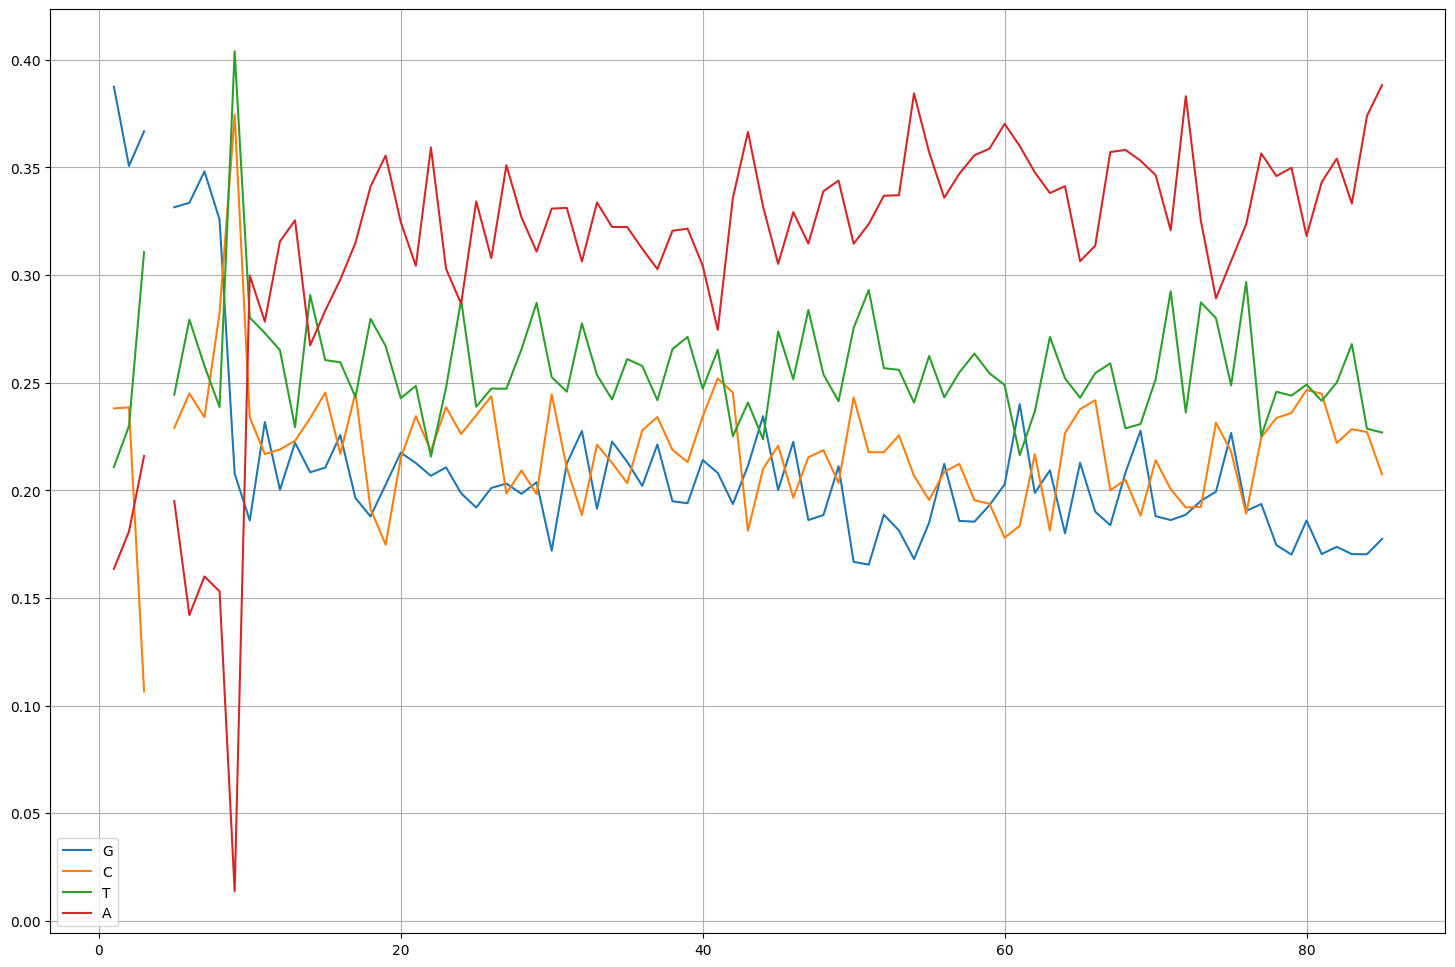

In [16]:
base_proportions.T.plot(kind='line', figsize=(18, 12))
plt.grid(True, which='major')


# Coordinate Extraction

Next, we load each read and check it against the expected patterns, discarding any which do not match.

For those reads that pass filtering, we store the barcode and the x and y coordinates (local to the tile) in dictionaries and then to disk using pickle files.

We also save a small number of the reads (10000 per tile) to a seperate file allowing fast identifications of tiles -> Nova-ST chips later.

In [17]:
tiles_dir = '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data/' # Path to the folder to output results

In [18]:
if not os.path.isdir(tiles_dir):
    os.mkdir(tiles_dir)

In [19]:
bc_pattern = 'NNVNBVNNVNNVNNVNNVNNVNNVNNVNNNNN'
filter_list = []
for n, b in enumerate(bc_pattern):
    if b == 'V':
        filter_list.append((n, 'T'))
    elif b == 'B':
        filter_list.append((n, 'A'))
    else:
        continue


In [20]:
filter_list

[(2, 'T'),
 (4, 'A'),
 (5, 'T'),
 (8, 'T'),
 (11, 'T'),
 (14, 'T'),
 (17, 'T'),
 (20, 'T'),
 (23, 'T'),
 (26, 'T')]

In [21]:
def is_read_bad(seq, filter_list, allowed_mismatches=0):
    bad_count = 0
    for n, not_base in filter_list:
        if seq[n] == not_base:
            bad_count += 1
        if bad_count > allowed_mismatches:
            return True
    return False
        

In [22]:
def extract_coords(tileinfo, subset_size = 10000):
    fastq_dir, tiles_dir, tile_id = tileinfo
    with pysam.FastxFile(f"{fastq_dir}/{tile_id}.fastq.gz", persist=False) as fh:
        total_bad = 0
        tile_data = {}
        subset = set()
        for en, entry in enumerate(fh):
            seq = entry.sequence
            # Don't save barcodes which don't match the expected pattern
            if is_read_bad(seq, filter_list, allowed_mismatches=0):
                total_bad += 1
                continue
            _, x, y = entry.name.split(":")[-3:]
            tile_data[seq] = (x, y)
            if en < subset_size:
                subset.add(seq)
        with open(f"{tiles_dir}/{tile_id}_barcodes.pickle", "wb") as tile_fh:
            pickle.dump(tile_data, tile_fh)
        return {
            "tile": tile_id,
            "data": f"{tiles_dir}/{tile_id}_barcodes.pickle",
            "subset": subset,
            "good_barcodes": en - total_bad,
            "bad_barcodes": total_bad,
        }

In [23]:
all_tiles_data = []
for tile in tile_fastqs:
    tile = tile.split(".")[0]
    all_tiles_data.append((tiles_fastq_dir, tiles_dir, tile))

In [25]:
all_tiles_data[:5]

[('/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data/',
  '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data/',
  'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_2_sequence_tile_1610'),
 ('/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data/',
  '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data/',
  'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_2_sequence_tile_1509'),
 ('/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data/',
  '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data/',
  'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_1_sequence_tile_2506'),
 ('/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data/',
  '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data/',
  'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_2_sequence_tile_1211'),
 ('/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data/',
  '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data/',
  'AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_1_sequence_tile_1101')]

In [26]:
from multiprocessing import Pool

In [27]:
with Pool(processes=70) as pool:
    results = pool.map(extract_coords, all_tiles_data)

In [28]:
total_bad_reads = 0
total_good_reads = 0
for tile in results:
    total_bad_reads += tile['bad_barcodes']
    total_good_reads += tile['good_barcodes']

print('Final counts:')
print(f"Total good barcodes: {total_good_reads}")
print(f"Total bad barcodes: {total_bad_reads}")

Final counts:
Total good barcodes: 511359535
Total bad barcodes: 507607833


In [29]:
print(f'{total_bad_reads / (total_good_reads + total_bad_reads) * 100:2f}% of barcodes were bad')

49.815907% of barcodes were bad


In [30]:
subset_datas = c.defaultdict(lambda: c.defaultdict(set))
for tile in results:
    tile_info = tile['tile']
    lane = tile_info.split('_')[0]
    surface = tile_info.split('_')[1][0]
    swath = tile_info.split('_')[1][1]
    tile_no = tile_info.split('_')[1][2:]
    subset_datas[f'{lane}_{surface}{swath}'][tile_no].update(tile['subset'])


for subset in subset_datas:
    with open(f'{tiles_dir}/{subset}_subset_barcodes.pickle', 'wb') as fh:
        pickle.dump(subset_datas[subset], fh)

In [35]:
f'{lane}_{surface}{swath}'

'AAGMTVHM5_No'

In [38]:
tile_no

'vaST'